In [4]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob
import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [5]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk('D:/Downloads/liver-tumor-segmentation'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        file_list.append((dirname,filename)) 

for dirname, _, filenames in os.walk('D:/Downloads/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname,filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)    

,dirname,filename
80,D:/Downloads/liver-tumor-segmentation-part-2\segmentations,segmentation-0.nii
81,D:/Downloads/liver-tumor-segmentation-part-2\segmentations,segmentation-1.nii
82,D:/Downloads/liver-tumor-segmentation-part-2\segmentations,segmentation-10.nii
83,D:/Downloads/liver-tumor-segmentation-part-2\segmentations,segmentation-100.nii
84,D:/Downloads/liver-tumor-segmentation-part-2\segmentations,segmentation-101.nii
...,...,...
45,D:/Downloads/liver-tumor-segmentation\volume_pt6,volume-95.nii
46,D:/Downloads/liver-tumor-segmentation\volume_pt6,volume-96.nii
47,D:/Downloads/liver-tumor-segmentation\volume_pt6,volume-97.nii
48,D:/Downloads/liver-tumor-segmentation\volume_pt6,volume-98.nii


In [6]:
# Map CT scan and label 

df_files["mask_dirname"] = "" ; df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "D:/Downloads/liver-tumor-segmentation-part-2/segmentations"

df_files_test= df_files[df_files.mask_filename=='']
# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 
print(len(df_files))
df_files
#df_files_test

131


,dirname,filename,mask_dirname,mask_filename
0,D:/Downloads/liver-tumor-segmentation-part-2\volume_pt1,volume-0.nii,D:/Downloads/liver-tumor-segmentation-part-2/segmentations,segmentation-0.nii
1,D:/Downloads/liver-tumor-segmentation-part-2\volume_pt1,volume-1.nii,D:/Downloads/liver-tumor-segmentation-part-2/segmentations,segmentation-1.nii
2,D:/Downloads/liver-tumor-segmentation-part-2\volume_pt1,volume-10.nii,D:/Downloads/liver-tumor-segmentation-part-2/segmentations,segmentation-10.nii
3,D:/Downloads/liver-tumor-segmentation\volume_pt6,volume-100.nii,D:/Downloads/liver-tumor-segmentation-part-2/segmentations,segmentation-100.nii
4,D:/Downloads/liver-tumor-segmentation\volume_pt8,volume-101.nii,D:/Downloads/liver-tumor-segmentation-part-2/segmentations,segmentation-101.nii
...,...,...,...,...
126,D:/Downloads/liver-tumor-segmentation\volume_pt6,volume-95.nii,D:/Downloads/liver-tumor-segmentation-part-2/segmentations,segmentation-95.nii
127,D:/Downloads/liver-tumor-segmentation\volume_pt6,volume-96.nii,D:/Downloads/liver-tumor-segmentation-part-2/segmentations,segmentation-96.nii
128,D:/Downloads/liver-tumor-segmentation\volume_pt6,volume-97.nii,D:/Downloads/liver-tumor-segmentation-part-2/segmentations,segmentation-97.nii
129,D:/Downloads/liver-tumor-segmentation\volume_pt6,volume-98.nii,D:/Downloads/liver-tumor-segmentation-part-2/segmentations,segmentation-98.nii


In [7]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [8]:
# Read sample
sample = 0
sample_ct   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
print(sample_ct.shape) 
print(sample_mask.shape)
print(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])

(512, 512, 75)
(512, 512, 75)
D:/Downloads/liver-tumor-segmentation-part-2\volume_pt1/volume-0.nii


In [9]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


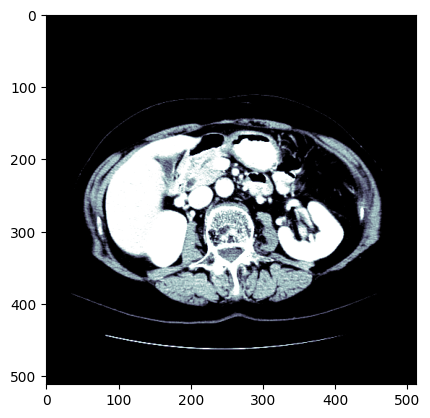

In [27]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

plt.imshow(tensor(sample_ct[...,50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [28]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')


    plt.show()

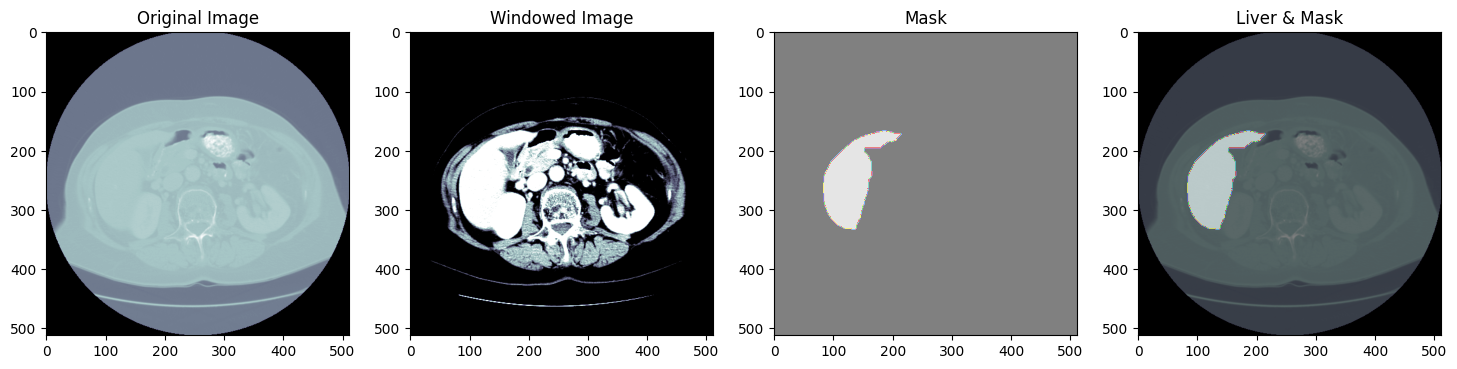

In [29]:
sample=50
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[...,sample], sample_mask[...,sample]])

In [30]:
# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print( np.array((unique, counts)).T)

[[     0 252049]
 [     1  10095]]


<Axes: >

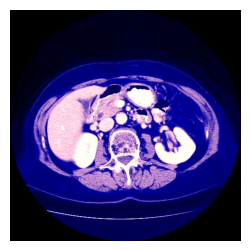

In [31]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    ''''"A function to split the range of pixel values into groups, 
    such that each group has around the same number of pixels"'''
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs=subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver,dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0])

In [32]:
df_files_1=df_files[0:30]
df_files_1

,dirname,filename,mask_dirname,mask_filename
0,D:/Downloads/liver-tumor-segmentation-part-2\volume_pt1,volume-0.nii,D:/Downloads/liver-tumor-segmentation-part-2/segmentations,segmentation-0.nii
1,D:/Downloads/liver-tumor-segmentation-part-2\volume_pt1,volume-1.nii,D:/Downloads/liver-tumor-segmentation-part-2/segmentations,segmentation-1.nii
2,D:/Downloads/liver-tumor-segmentation-part-2\volume_pt1,volume-10.nii,D:/Downloads/liver-tumor-segmentation-part-2/segmentations,segmentation-10.nii
3,D:/Downloads/liver-tumor-segmentation\volume_pt6,volume-100.nii,D:/Downloads/liver-tumor-segmentation-part-2/segmentations,segmentation-100.nii
4,D:/Downloads/liver-tumor-segmentation\volume_pt8,volume-101.nii,D:/Downloads/liver-tumor-segmentation-part-2/segmentations,segmentation-101.nii
5,D:/Downloads/liver-tumor-segmentation\volume_pt8,volume-102.nii,D:/Downloads/liver-tumor-segmentation-part-2/segmentations,segmentation-102.nii
6,D:/Downloads/liver-tumor-segmentation\volume_pt8,volume-103.nii,D:/Downloads/liver-tumor-segmentation-part-2/segmentations,segmentation-103.nii
7,D:/Downloads/liver-tumor-segmentation\volume_pt8,volume-104.nii,D:/Downloads/liver-tumor-segmentation-part-2/segmentations,segmentation-104.nii
8,D:/Downloads/liver-tumor-segmentation\volume_pt8,volume-105.nii,D:/Downloads/liver-tumor-segmentation-part-2/segmentations,segmentation-105.nii
9,D:/Downloads/liver-tumor-segmentation\volume_pt8,volume-106.nii,D:/Downloads/liver-tumor-segmentation-part-2/segmentations,segmentation-106.nii


In [33]:
import random

GENERATE_JPG_FILES = True   # warning: generation takes ~ 1h

if GENERATE_JPG_FILES:
    path = Path(".")

    os.makedirs('train_images', exist_ok=True)
    os.makedirs('train_masks', exist_ok=True)

    # Randomly select 1/3 of the indices
    random_indices = random.sample(range(len(df_files)), len(df_files) // 2)

    for ii in tqdm(random_indices):  # take 1/3 nii files for training
        curr_ct = read_nii(df_files.loc[ii, 'dirname'] + "/" + df_files.loc[ii, 'filename'])
        curr_mask = read_nii(df_files.loc[ii, 'mask_dirname'] + "/" + df_files.loc[ii, 'mask_filename'])
        curr_file_name = str(df_files.loc[ii, 'filename']).split('.')[0]
        curr_dim = curr_ct.shape[2]  # 512, 512, curr_dim

        for curr_slice in range(0, curr_dim, 2):  # export every 2nd slice for training
            data = tensor(curr_ct[..., curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[..., curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver, dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    path = Path("D:/Downloads/liver-segmentation-with-fastai-v2")  # read jpg from saved kernel output


  0%|          | 0/65 [00:00<?, ?it/s]

In [35]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from sklearn.model_selection import train_test_split

# Set the directories
images_dir = 'train_images'
masks_dir = 'train_masks'

# Get the list of image file names
all_image_file_names = sorted(os.listdir(images_dir))

# Randomly select 9000 images
selected_image_file_names = random.sample(all_image_file_names, 9000)

# Load selected images and masks with resizing
target_size = (128, 128)
images = [np.array(Image.open(os.path.join(images_dir, fname)).resize(target_size)) for fname in selected_image_file_names]

# Adjust file extension for masks
mask_file_names = [fname.replace('.jpg', '_mask.png') for fname in selected_image_file_names]
masks = [np.array(Image.open(os.path.join(masks_dir, fname)).resize(target_size)) for fname in mask_file_names]

# Convert the lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Normalize images to [0, 1]
images = images / 255.0

# Reshape masks to include a channel dimension
masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], 1))


ImportError: cannot import name 'get_model_proto' from 'tensorflow.python.data.experimental.ops.iterator_ops' (c:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\data\experimental\ops\iterator_ops.py)

In [18]:
# Split the data into training, validation, and test sets
# 70% training, 20% validation, 10% test
x_train, x_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=1/3, random_state=42)

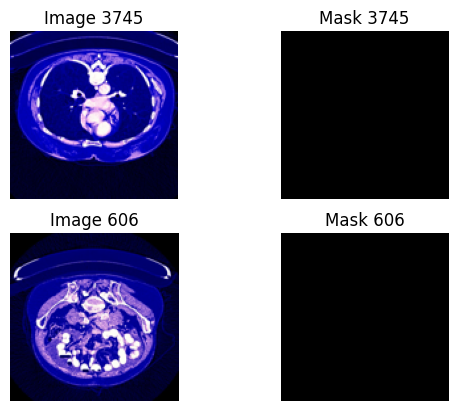

In [19]:
import matplotlib.pyplot as plt

# Function to display images and masks
def display_images_and_masks(images, masks, num_samples=2):
    # Randomly select samples
    sample_indices = random.sample(range(images.shape[0]), num_samples)

    for i in range(num_samples):
        index = sample_indices[i]

        # Display the image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(images[index])
        plt.title("Image {}".format(index))
        plt.axis("off")

        # Display the mask
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(masks[index].squeeze(), cmap='gray')
        plt.title("Mask {}".format(index))
        plt.axis("off")

    plt.show()

# Display two random images and masks
display_images_and_masks(x_train, y_train)

In [20]:
y_train.shape, x_train.shape

((6300, 128, 128, 1), (6300, 128, 128, 3))

In [56]:
from tensorflow import keras
from tensorflow.keras import layers

def create_fcn_model(input_shape=(128, 128, 3), target_shape=(128, 128, 1)):
    model = keras.Sequential()

    # Encoder
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Decoder with Skip Connections
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    # Output layer
    model.add(layers.Conv2D(1, (1, 1), activation='sigmoid'))  # Assuming binary classification

    # Crop to match the target shape
    crop_height = (model.output_shape[1] - target_shape[0]) // 2
    crop_width = (model.output_shape[2] - target_shape[1]) // 2
    model.add(layers.Cropping2D(cropping=((crop_height, crop_height), (crop_width, crop_width))))

    return model
# Create the FCN model
model = create_fcn_model()

# Display the model summary
model.summary()
model.save('fcn_model.h5')

c:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 1,537,217 (5.86 MB)

 Trainable params: 1,534,977 (5.86 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [2]:
def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    union = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (union - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

In [3]:
import tensorflow as tf

def volume_intersection(y_true, y_pred):
    return tf.reduce_sum(y_true * y_pred, axis=(1,2))

def volume_union(y_true, y_pred):
    return tf.reduce_sum(y_true + y_pred, axis=(1,2))

ImportError: cannot import name 'get_model_proto' from 'tensorflow.python.data.experimental.ops.iterator_ops' (c:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\data\experimental\ops\iterator_ops.py)

In [61]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"    

from keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Input, Concatenate, Dense, BatchNormalization, Convolution1D, Convolution2D, MaxPooling1D, MaxPooling2D, RepeatVector, Dense, Dropout, Activation, Flatten, LeakyReLU, Conv1D, LSTM, Conv2D, MaxPooling2D, ConvLSTM2D
from keras import utils
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras import regularizers
from keras.models import save_model, load_model, model_from_json

checkpoint = ModelCheckpoint("fcn_model.weights.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Пример остальных колбэков
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)
csv_logger = CSVLogger('training.log')

#checkpoint = tf.keras.callbacks.ModelCheckpoint("fcn_model.h5", monitor='val_loss', verbose=1, patience = 3,save_best_only=True,
                                                #save_weights_only=True, mode='auto')
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

In [1]:
from tensorflow.keras.optimizers import Adam
# Compile the model [0.001,0001, 6e-e]
model.compile(optimizer=Adam(lr=.001),loss='binary_crossentropy',
              metrics=[jaccard_distance])

ImportError: cannot import name 'get_model_proto' from 'tensorflow.python.data.experimental.ops.iterator_ops' (c:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\data\experimental\ops\iterator_ops.py)

In [55]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

# Определим функцию потерь jaccard_distance
def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    y_true = tf.cast(y_true, tf.float32)  # Преобразовать тип данных y_true к float32
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2))
    union = tf.reduce_sum(y_true + y_pred, axis=(1, 2))
    jac = (intersection + smooth) / (union - intersection + smooth)
    return tf.reduce_mean(1 - jac)

# Создадим колбэк ModelCheckpoint для сохранения лучших весов модели
checkpoint = ModelCheckpoint("fcn_model.weights.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

# Теперь обучим модель, используя функцию потерь jaccard_distance как метрику
history = model.fit(x_train, y_train, epochs=5, batch_size=16,
                    validation_data=(x_valid, y_valid), callbacks=[reduce_lr, checkpoint])
model.save('fcn_model.h5')

MemoryError: Unable to allocate 1.15 GiB for an array with shape (6300, 128, 128, 3) and data type float32

In [54]:
import matplotlib.pyplot as plt
def show_history(history, train, validation):
    plt.plot(history.history[train])
    plt.plot(history.history[validation])
    plt.title('Train History')
    plt.ylabel('train') 
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='center right')
    plt.show()
show_history(history, 'jaccard_distance', 'val_jaccard_distance')

NameError: name 'history' is not defined

In [53]:
show_history(history, 'loss', 'val_loss')

NameError: name 'history' is not defined

In [104]:
scores = model.evaluate(x_valid, y_valid)
scores[1]

ValueError: You must call `compile()` before using the model.

In [27]:
prediction = model.predict(x_test)
#print(prediction)
#print(y_test)

29/29 [==============================] - 2s 65ms/step


In [28]:
test_scores = model.evaluate(x_test, y_test)
test_scores[1]

29/29 [==============================] - 1s 44ms/step - loss: 0.0258 - jaccard_distance: 46.1944


46.194366455078125

1/1 [==============================] - 1s 552ms/step


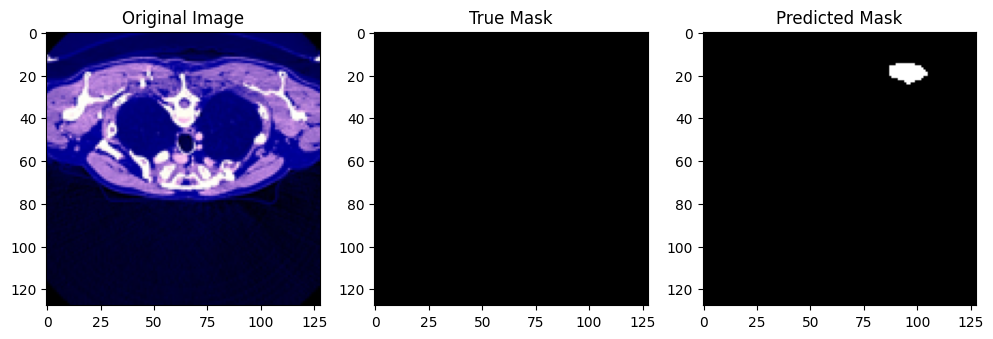

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have x_test and y_test
# Replace this with the actual index of the image you want to visualize
image_index = 44

# Load the image and true mask
input_image = x_test[image_index]
true_mask = y_test[image_index]

# Obtain the predicted mask from model2
predicted_mask = model.predict(np.expand_dims(input_image, axis=0))[0]

# Threshold the predicted mask (assuming it's a binary mask)
threshold = 0.5  # Adjust this threshold based on your model's output
predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

# Plotting
plt.figure(figsize=(12, 4))

# Plot original image
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Original Image')

# Plot true mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='gray')
plt.title('True Mask')

# Plot predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_binary[:, :, 0], cmap='gray')
plt.title('Predicted Mask')

plt.show()


In [64]:
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

# U-Net model architecture for liver segmentation
def unet_model(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Middle
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    up4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    merge4 = concatenate([conv2, up4], axis=3)

    up5 = UpSampling2D(size=(2, 2))(merge4)
    up5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)
    up5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)
    merge5 = concatenate([conv1, up5], axis=3)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(merge5)

    model1 = Model(inputs=inputs, outputs=outputs)

    return model1

# Build the U-Net model
model1 = unet_model()

# Display the model summary
model1.summary()
model1.save('unet_model.h5')

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_10[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_12[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_14[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 64, 64,    │          0 │ conv2d_15[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │     73,792 │ up_sampling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_16[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_13[0][0],  │
│ (Concatenate)       │ 128)              │            │ conv2d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 128, 128,  │          0 │ concatenate[0][0] │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │     36,896 │ up_sampling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_18[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_11[0][0],

 Total params: 443,937 (1.69 MB)

 Trainable params: 443,937 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
from tensorflow.keras.utils import plot_model
tf.keras.utils.plot_model(model1, show_shapes=True)

model1 = create_unet_model(512,512,)

plot_model(model1, to_file='unet_model.png', show_shapes=False)

You must install pydot (`pip install pydot`) for `plot_model` to work.


TypeError: create_unet_model() missing 3 required positional arguments: 'arch', 'n_out', and 'img_size'

In [63]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("unet_model.h5", monitor='val_loss', verbose=1, patience = 3,save_best_only=True,
                                                mode='auto')

ValueError: You must call `compile()` before using the model.

In [58]:
from tensorflow.keras.optimizers import Adam
# Compile the model [0.001,0001, 6e-e]
model1.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              loss= 'mean_absolute_error', metrics=[jaccard_distance])

NameError: name 'model1' is not defined

In [57]:
# Train the model
history1 = model1.fit(x_train, y_train, epochs=5, batch_size=16,
          validation_data=(x_valid, y_valid), callbacks=[checkpoint])
model1.save('unet_model.h5')

NameError: name 'model1' is not defined

In [56]:
scores1 = model1.evaluate(x_valid, y_valid)
scores1[1]

NameError: name 'model1' is not defined

In [54]:
prediction1 = model1.predict(x_test)
#print(prediction)
#print(y_test)

NameError: name 'model1' is not defined

In [55]:
test_scores1 = model1.evaluate(x_test, y_test)
test_scores1[1]

NameError: name 'model1' is not defined

1/1 [==============================] - 0s 275ms/step


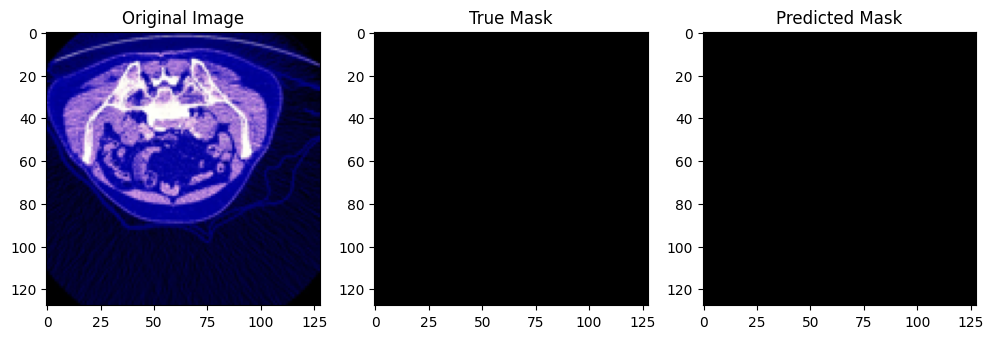

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have x_test and y_test
# Replace this with the actual index of the image you want to visualize
image_index = 40

# Load the image and true mask
input_image = x_test[image_index]
true_mask = y_test[image_index]

# Obtain the predicted mask from model2
predicted_mask = model1.predict(np.expand_dims(input_image, axis=0))[0]

# Threshold the predicted mask (assuming it's a binary mask)
threshold = 0.5  # Adjust this threshold based on your model's output
predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

# Plotting
plt.figure(figsize=(12, 4))

# Plot original image
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Original Image')

# Plot true mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='gray')
plt.title('True Mask')

# Plot predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_binary[:, :, 0], cmap='gray')
plt.title('Predicted Mask')

plt.show()


In [39]:
def segnet_model(input_shape=(128, 128, 3)):
    model2 = tf.keras.Sequential()

    # Encoder
    model2.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.Conv2D(64, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model2.add(layers.Conv2D(128, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.Conv2D(128, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model2.add(layers.Conv2D(256, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.Conv2D(256, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.Conv2D(256, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Decoder
    model2.add(layers.UpSampling2D(size=(2, 2)))
    model2.add(layers.Conv2D(256, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.Conv2D(256, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.Conv2D(256, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))

    model2.add(layers.UpSampling2D(size=(2, 2)))
    model2.add(layers.Conv2D(128, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.Conv2D(128, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))

    model2.add(layers.UpSampling2D(size=(2, 2)))
    model2.add(layers.Conv2D(64, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))
    model2.add(layers.Conv2D(64, (3, 3), padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Activation('relu'))

    # Output layer
    model2.add(layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same'))

    return model2

# Create SegNet model
model2 = segnet_model(input_shape=(128, 128, 3))


# Display the model summary
model2.summary()
model2.save('segnet_model2.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_9 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_22 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_10 (Ba  (None, 128, 128, 64)      256       
 tchNormalization)                                               
                                                                 
 activation_1 (Activation)   (None, 128, 128, 64)     

In [45]:
from tensorflow.keras.utils import plot_model
#tf.keras.utils.plot_model(model1, show_shapes=True)
# Assuming you have created the model using the create_fcn_model function
#model1 = create_unet_model()

# Save the model architecture plot to a file
#plot_model(model2, to_file='segnet_model.png', show_shapes=False)

In [53]:
import tensorflow as tf

# Определение колбэка для сохранения весов
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="segnet_model2.weights.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,  # Сохраняем только веса модели
    mode='auto'
)

# Использование колбэка при обучении модели
model.fit(x_train, y_train, epochs=10, batch_size=16, validation_data=(x_val, y_val), callbacks=[checkpoint])


NameError: name 'x_val' is not defined

In [42]:
from tensorflow.keras.optimizers import Adam
# Compile the model [0.001,0001, 6e-e]
model2.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              loss= 'binary_crossentropy', metrics=[jaccard_distance])

In [43]:
# Train the model
history2 = model2.fit(x_train, y_train, epochs=5, batch_size=16,
          validation_data=(x_valid, y_valid), callbacks=[checkpoint])
model2.save('segnet_model2.h5')

Epoch 1/5
394/394 [==============================] - ETA: 0s - loss: 0.0773 - jaccard_distance: 71.2026
Epoch 1: val_loss improved from inf to 0.34652, saving model to segnet_model2.h5
394/394 [==============================] - 90s 193ms/step - loss: 0.0773 - jaccard_distance: 71.2026 - val_loss: 0.3465 - val_jaccard_distance: 82.0698
Epoch 2/5
394/394 [==============================] - ETA: 0s - loss: 0.0255 - jaccard_distance: 44.2243
Epoch 2: val_loss improved from 0.34652 to 0.10652, saving model to segnet_model2.h5
394/394 [==============================] - 70s 179ms/step - loss: 0.0255 - jaccard_distance: 44.2243 - val_loss: 0.1065 - val_jaccard_distance: 41.2967
Epoch 3/5
394/394 [==============================] - ETA: 0s - loss: 0.0266 - jaccard_distance: 38.0891
Epoch 3: val_loss did not improve from 0.10652
394/394 [==============================] - 70s 178ms/step - loss: 0.0266 - jaccard_distance: 38.0891 - val_loss: 0.1849 - val_jaccard_distance: 83.3061
Epoch 4/5
394/394 [

In [44]:
scores2 = model2.evaluate(x_valid, y_valid)
scores2[1]

57/57 [==============================] - 9s 100ms/step - loss: 9.1571e-04 - jaccard_distance: 31.0863


31.086257934570312

In [45]:
prediction2 = model2.predict(x_test)
#print(prediction)
#print(y_test)


29/29 [==============================] - 4s 130ms/step


In [46]:
test_scores2 = model2.evaluate(x_test, y_test)
test_scores2[1]

29/29 [==============================] - 3s 99ms/step - loss: 0.0013 - jaccard_distance: 31.3943


31.394315719604492

1/1 [==============================] - 1s 558ms/step


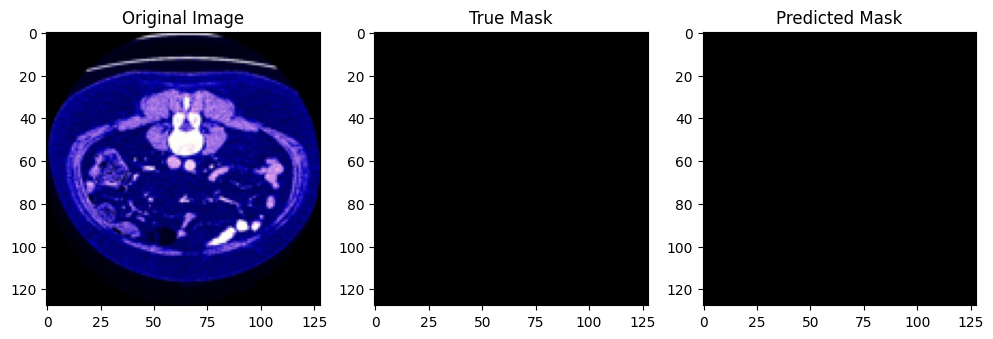

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have x_test and y_test
# Replace this with the actual index of the image you want to visualize
image_index = 45

# Load the image and true mask
input_image = x_test[image_index]
true_mask = y_test[image_index]

# Obtain the predicted mask from model2
predicted_mask = model2.predict(np.expand_dims(input_image, axis=0))[0]

# Threshold the predicted mask (assuming it's a binary mask)
threshold = 0.5  # Adjust this threshold based on your model's output
predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

# Plotting
plt.figure(figsize=(12, 4))

# Plot original image
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Original Image')

# Plot true mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='gray')
plt.title('True Mask')

# Plot predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_binary[:, :, 0], cmap='gray')
plt.title('Predicted Mask')

plt.show()

In [48]:
# Step 2: Apply weights to the predictions
unet_weight = 0.98
fcn_weight = 0.71
segnet_weight = 0.99
sum_weights = unet_weight + fcn_weight + segnet_weight

w_unet = unet_weight / sum_weights
w_fcn = fcn_weight / sum_weights
w_segnet = segnet_weight / sum_weights

# Step 3: Take element-wise maximum prediction
weighted_prediction = np.maximum(w_unet * prediction1, w_fcn * prediction, w_segnet * prediction2)


In [49]:
# Step 4: Take argmax along the last axis
final_prediction = np.argmax(weighted_prediction, axis=-1)

# Step 5: Calculate the testing score using the combined predictions
test_scores1 = model2.evaluate(x_test, y_test)
test_scores2 = model1.evaluate(x_test, y_test)
weighted_test_score = w_unet * test_scores[1] + w_fcn * model.evaluate(x_test, y_test)[1] + w_segnet*test_scores1[1]

print(f'Testing score with weighted predictions: {weighted_test_score}')

29/29 [==============================] - 1s 44ms/step - loss: 0.0258 - jaccard_distance: 46.1944
Testing score with weighted predictions: 40.72718353413824


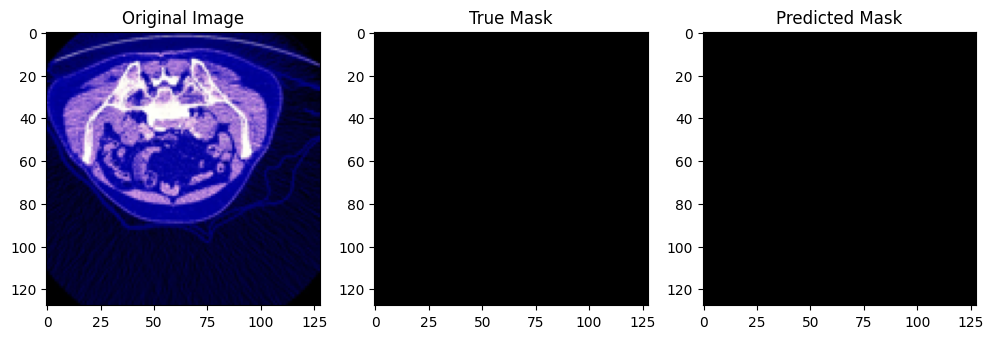

In [50]:
import matplotlib.pyplot as plt

# Assuming you have an image, true mask, and final_prediction
image_index = 40  # Adjust this based on the image you want to visualize

# Load the image, true mask, and predicted mask
input_image = x_test[image_index]
true_mask = y_test[image_index]
predicted_mask = final_prediction[image_index]

# Plotting
plt.figure(figsize=(12, 4))

# Plot original image
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Original Image')

# Plot true mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='gray')
plt.title('True Mask')

# Plot predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')

plt.show()